# Portfolio Construction

<div style='text-align: justify;'>
The aim of this section is the implementation of a portfolio optimization procedure and the examination of potential diversification benefits from emerging markets. To estimates the optimal weights the portfolio optimization approach of Markowitz will be used.
In the existing literature a simple and standard way to optimize a portfolio, is to identify the weights that will maximize the return for a given level of risk.
</div>
From a mathematical perspective, the objective of this procedure is the minimization of: 
$$ minσ_{p}^{2} = \sum \limits_{i=1} ^{N} \sum \limits_{j=1} ^{N}w_{i}w_{j}σ_{i,j}$$

$$Subject to:\sum \limits_{i=1} ^{N}w_{i}=1$$
$$0 \leq w_{i} \leq 1$$
<div style='text-align: justify;'>
The second constrain is to ensure that the short selling is not allowed. This is a reasonable restriction because in many emerging markets the short selling is prohibited.
</div>

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def import_data(path):
    # The data were downloaded from investment.com
    # Load Market index logarithmic returns
    df = pd.read_csv(path)

    # Change column name
    df.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)

    # Convert string to date time
    df['Date'] = pd.to_datetime(df['Date'])

    # Remove time
    df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')

    # Set frequency to avoid errors later in the VAR model
    df['Date'] = pd.DatetimeIndex(df['Date']).to_period('B')
    #df['Date'] = pd.DatetimeIndex(df['Date'])
    # Set Datetime index
    df.set_index('Date', inplace=True)
    return df

In [7]:
from scipy.optimize import minimize
class my_mgarch:
#https: // github.com / srivastavaprashant / mgarch / blob / master / mgarch / mgarch.py
    def __init__(self, dist='norm'):
        if dist == 'norm' or dist == 't':
            self.dist = dist
        else:
            print("Takes pdf name as param: 'norm' or 't'.")

    def garch_fit(self, returns):
        res = minimize(self.garch_loglike, (0.01, 0.01, 0.94), args=returns,
                       bounds=((1e-6, 1), (1e-6, 1), (1e-6, 1)))
        return res.x

    def garch_loglike(self, params, returns):
        T = len(returns)
        var_t = self.garch_var(params, returns)
        LogL = np.sum(-np.log(2 * np.pi * var_t)) - np.sum((returns.A1 ** 2) / (2 * var_t))
        return -LogL

    def garch_var(self, params, returns):
        T = len(returns)
        omega = params[0]
        alpha = params[1]
        beta = params[2]
        var_t = np.zeros(T)
        for i in range(T):
            if i == 0:
                var_t[i] = returns[i] ** 2
            else:
                var_t[i] = omega + alpha * (returns[i - 1] ** 2) + beta * var_t[i - 1]
        return var_t

    def mgarch_loglike(self, params, D_t):
        # No of assets
        a = params[0]
        b = params[1]
        Q_bar = np.cov(self.rt.reshape(self.N, self.T))

        Q_t = np.zeros((self.T, self.N, self.N))
        R_t = np.zeros((self.T, self.N, self.N))
        H_t = np.zeros((self.T, self.N, self.N))

        Q_t[0] = np.matmul(self.rt[0].T / 2, self.rt[0] / 2)

        loglike = 0
        for i in range(1, self.T):
            dts = np.diag(D_t[i])
            dtinv = np.linalg.inv(dts)
            et = dtinv * self.rt[i].T
            Q_t[i] = (1 - a - b) * Q_bar + a * (et * et.T) + b * Q_t[i - 1]
            qts = np.linalg.inv(np.sqrt(np.diag(np.diag(Q_t[i]))))

            R_t[i] = np.matmul(qts, np.matmul(Q_t[i], qts))

            H_t[i] = np.matmul(dts, np.matmul(R_t[i], dts))

            loglike = loglike + self.N * np.log(2 * np.pi) + \
                      2 * np.log(D_t[i].sum()) + \
                      np.log(np.linalg.det(R_t[i])) + \
                      np.matmul(self.rt[i], (np.matmul(np.linalg.inv(H_t[i]), self.rt[i].T)))

        return loglike

    def mgarch_logliket(self, params, D_t):
        # No of assets
        a = params[0]
        b = params[1]
        dof = params[2]
        Q_bar = np.cov(self.rt.reshape(self.N, self.T))

        Q_t = np.zeros((self.T, self.N, self.N))
        R_t = np.zeros((self.T, self.N, self.N))
        H_t = np.zeros((self.T, self.N, self.N))

        Q_t[0] = np.matmul(self.rt[0].T / 2, self.rt[0] / 2)

        loglike = 0
        for i in range(1, self.T):
            dts = np.diag(D_t[i])
            dtinv = np.linalg.inv(dts)
            et = dtinv * self.rt[i].T
            Q_t[i] = (1 - a - b) * Q_bar + a * (et * et.T) + b * Q_t[i - 1]
            qts = np.linalg.inv(np.sqrt(np.diag(np.diag(Q_t[i]))))

            R_t[i] = np.matmul(qts, np.matmul(Q_t[i], qts))

            H_t[i] = np.matmul(dts, np.matmul(R_t[i], dts))

            loglike = loglike + np.log(gamma((self.N + dof) / 2.)) - np.log(gamma(dof / 2)) \
                      - (self.N / 2.) * np.log(np.pi * (dof - 2)) - np.log(np.linalg.det(H_t[i])) \
                      - ((dof + self.N) * (((np.matmul(self.rt[i],
                                                       (np.matmul(np.linalg.inv(H_t[i]), self.rt[i].T)))) / (
                                                        dof - 2.)) + 1) / 2.)

        return -loglike

    def predict(self, ndays=1):
        if 'a' in dir(self):
            Q_bar = np.cov(self.rt.reshape(self.N, self.T))

            Q_t = np.zeros((self.T, self.N, self.N))
            R_t = np.zeros((self.T, self.N, self.N))
            H_t = np.zeros((self.T, self.N, self.N))

            Q_t[0] = np.matmul(self.rt[0].T / 2, self.rt[0] / 2)

            loglike = 0
            # For each observation
            for i in range(1, self.T):
                # D_t is the standard deviation from the Garch model
                dts = np.diag(self.D_t[i])
                dtinv = np.linalg.inv(dts)
                et = dtinv * self.rt[i].T
                # Conditional Covariance Matrix
                Q_t[i] = (1 - self.a - self.b) * Q_bar + self.a * (et * et.T) + self.b * Q_t[i - 1]
                # We take the diag of the variance and again the diag and then the sqrt
                # Since the Q is var-cov matrix this will return a NxN diagonal matrix where the first diagonal has the
                # the standard deviation of the series and the rest elements are zero
                # this is a property of python
                qts = np.linalg.inv(np.sqrt(np.diag(np.diag(Q_t[i]))))

                # R_t is the correlation matrix
                R_t[i] = np.matmul(qts, np.matmul(Q_t[i], qts))

                H_t[i] = np.matmul(dts, np.matmul(R_t[i], dts))

            if self.dist == 'norm':
                return {'dist': self.dist, 'cov': H_t * np.sqrt(ndays), 'corr': R_t}
                #return {'dist': self.dist, 'cov': H_t[-1] * np.sqrt(ndays)}
            elif self.dist == 't':
                return {'dist': self.dist, 'dof': self.dof, 'cov': H_t[-1] * np.sqrt(ndays)}

        else:
            print('Model not fit')

    def fit(self, returns):
        # The aim of this function is to estimate the standard deviation of the series and the
        # parameters a and b
        self.rt = np.matrix(returns)

        self.T = self.rt.shape[0]
        self.N = self.rt.shape[1]

        if self.N == 1 or self.T == 1:
            return 'Required: 2d-array with columns > 2'
        self.mean = self.rt.mean(axis=0)
        self.rt = self.rt - self.mean

        D_t = np.zeros((self.T, self.N))
        # T: num of observations
        # N: num of assets
        for i in range(self.N):
            # params include the parameters of the GARCH model
            params = self.garch_fit(self.rt[:, i])
            # D_t is the standard deviation from the Garch model
            # garch_var estimates the variance of the time series using the Garch model
            # we apply sqrt to take the standard deviation
            D_t[:, i] = np.sqrt(self.garch_var(params, self.rt[:, i]))
        self.D_t = D_t
        if self.dist == 'norm':
            # we minimize the loglikelihood function with respect to a,b
            res = minimize(self.mgarch_loglike, (0.01, 0.94), args=D_t,
                           bounds=((1e-6, 1), (1e-6, 1)),
                           # options = {'maxiter':10000000, 'disp':True},
                           )
            self.a = res.x[0]
            self.b = res.x[1]

            return {'mu': self.mean, 'alpha': self.a, 'beta': self.b}
        elif self.dist == 't':
            res = minimize(self.mgarch_logliket, (0.01, 0.94, 3), args=D_t,
                           bounds=((1e-6, 1), (1e-6, 1), (3, None)),
                           # options = {'maxiter':10000000, 'disp':True},
                           )
            self.a = res.x[0]
            self.b = res.x[1]
            self.dof = res.x[2]
            return {'mu': self.mean, 'alpha': self.a, 'beta': self.b, 'dof': self.dof}


In [3]:
# Import Returns
path1="market_indexes_ret.csv"
market_return = import_data(path1)

In [4]:
# Split the data
train_length = int(len(market_return) * 0.90)

# We add the lagged values because for every market we assume that the prices are available at the same time
x_train = market_return[:train_length]
x_test = market_return[train_length:]

In [5]:
# Market indices selection
dev_country = 'US'
emer_countries = 'China'

In [6]:
# Take the returns that you need
rt = x_train[[dev_country,emer_countries]]

In [8]:
# Fit the DCC-Garch model
model = my_mgarch()
model.fit(rt)

{'mu': matrix([[ 5.18135567e-04, -8.01271134e-06]]),
 'alpha': 3.41057384616933e-05,
 'beta': 0.0455505543456597}

In [10]:
temp = model.predict()

In [11]:
# Time-varying correlation
DCC = temp['corr'][:,0,1]

In [12]:
# Time-varying covariance
tv_cov = temp['cov']

In [13]:
# Time-varying variance for the first country (US)
tv_var_y = tv_cov[:,0,0]

In [14]:
# Time-varying variance for the second country (China)
tv_var_x = tv_cov[:,1,1]

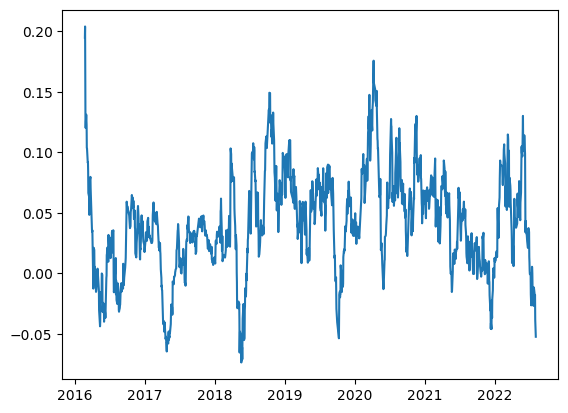

In [15]:
# Correlation plots
ma25_dcc = pd.DataFrame(DCC).rolling(25).mean().dropna()
dates_train=x_train['US'].iloc[24:].index.to_timestamp(freq=None, how='start')
ma25_dcc.set_index(dates_train, inplace=True)
plt.plot(ma25_dcc)

<div style='text-align: justify;'>
We aim to construct 100 random portfolios using the Markowitz approach. As there is evidence that the variance of the selected market indexes is not constant over time, the Garch model is employed. To capture the prevailing relationship between the market indices, instead of the unconditional covariance, we will use the conditional one. Particularly, from the results of the Garch model we will use the last observation of the time-varying covariance matrix. On top of that, as the time-varying correlation between the US and China is decreasing after 2022, this is an indication that potential diversification opportunities between the US and China might exist. 
    </div>

In [16]:
# Markowitz Theory
def rand_weights(n):
    # Restrictions
    # w > 0, No short selling
    # Sum up to 1
    w = np.random.rand(n)
    return w / sum(w)


def random_portfolio(returns, cov):
    # Returns the mean and standard deviation of returns for a random portfolio

    p = np.asmatrix(np.mean(returns, axis=0))
    w = np.asmatrix(rand_weights(returns.shape[1]))
    C = np.asmatrix(cov)

    mu = w * p.T
    sigma = np.sqrt(w * C * w.T)

    # This recursion reduces outliers to keep plots pretty
    return mu[0,0], sigma[0,0], w[0,0], w[0,1]

In [17]:
np.random.seed(123)
n_portfolios = 100
cov = tv_cov[-1]
portfolio = pd.DataFrame()
portfolio['means'], portfolio['stds'], portfolio['w_A'], portfolio['w_b'] = np.column_stack([
    random_portfolio(rt, cov)
    for _ in range(n_portfolios)
])

<div style='text-align: justify;'>
The optimal weight are the weight that minimize the risk of the investor or in other words the weights that correspond to the minimum standard deviation of the randomly generated portfolios.
</div>

In [18]:
optimal_port_index = portfolio['stds'].idxmin()
optimal_port_weights = portfolio.iloc[optimal_port_index,[2,3]]

### Optimal weights

In [32]:
results_weights = pd.DataFrame(optimal_port_weights.values, index=[dev_country,emer_countries], columns=["Optimal Weights"])
results_weights.head()

,Optimal Weights
US,0.323057
China,0.676943


Text(0.5, 1, 'Portfolios mean and std')

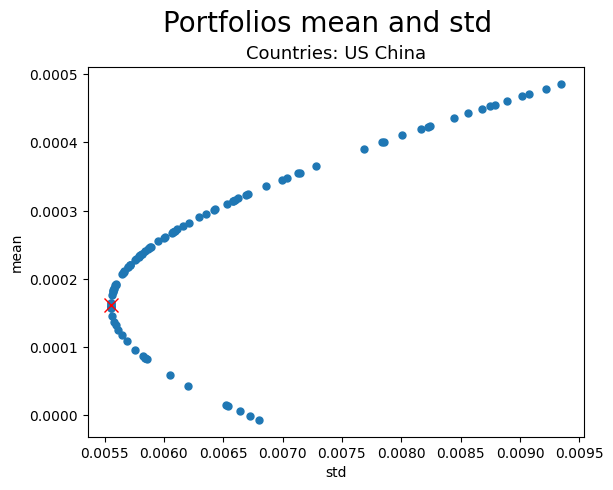

In [19]:
# Plot the results
fig = plt.figure()
plt.plot(portfolio['stds'], portfolio['means'], 'o', markersize=5)
plt.plot(portfolio.iloc[optimal_port_index,1],portfolio.iloc[optimal_port_index,0],'x',color='red', markersize=10)
plt.xlabel('std')
plt.ylabel('mean')
plt.title('Portfolios mean and std')
plt.title('Countries: '+dev_country+' '+emer_countries, fontsize=13)
plt.suptitle('Portfolios mean and std', fontsize=20, y=1)

## Compare optimal portfolio with return of market indexes


In [20]:
rt_test = x_test[[dev_country,emer_countries]]
p = np.asmatrix(np.mean(rt_test, axis=0))
w = np.asmatrix(optimal_port_weights)
C = np.asmatrix(cov)

In [21]:
# the returns are converted to arithmetic
# Arithmetic Return = exp(Logarithmic Return) - 1
port_ret = np.exp(w * p.T) - 1
temp = np.exp(w * np.asmatrix(rt_test).T) - 1

ret_A = (np.exp(rt_test.iloc[:,0].mean()) - 1)

ret_B = (np.exp(rt_test.iloc[:,1].mean()) -1)

In [22]:
# Annualized return
# Annualized Return = ((1 + ret) ^ (252)) - 1
an_port_ret = (((1 + port_ret[0,0])**(252)) - 1)
an_ret_A = (((1 + ret_A)**(252)) - 1)
an_ret_B = (((1 + ret_B)**(252)) - 1)


In [23]:
# Annualized Standard Deviation
an_std_port = np.sqrt(252)*np.sqrt(temp.var())
an_std_A = np.sqrt(252)*np.sqrt(rt_test.iloc[:,0].var())
an_std_B = np.sqrt(252)*np.sqrt(rt_test.iloc[:,1].var())

In [24]:
# Sharp Ratio
sharp_port = an_port_ret/an_std_port
sharp_A = an_ret_A/an_std_A
sharp_B = an_ret_B / an_std_B

In [25]:
data = [[an_port_ret, an_ret_A, an_ret_B], [an_std_port, an_std_A, an_std_B], [sharp_port, sharp_A, sharp_B]]
results = pd.DataFrame(data, columns=[['Portfolio', dev_country,emer_countries]], index=['Return','Std','Sharpe Ratio'])

## Final Results

In [26]:
results.head()

,Portfolio,US,China
Return,0.028183,0.020282,0.031975
Std,0.123042,0.214000,0.152597
Sharpe Ratio,0.229052,0.094777,0.209538


<div style='text-align: justify;'>
Clearly, it can be seen that the optimal portfolio had a better performance and with reduced risk, compared to the buy and hold strategy on S&P 500. The sharp ratio of the portfolio is larger, which indicates that the portfolio generated more return per unit of risk.
    </div>